In [1]:
import numpy as np
import scipy as sc
import matplotlib.patches as patch
from scipy import stats
from matplotlib.legend_handler import HandlerLine2D
from skimage import data, io, color, transform, exposure
from pprint import pprint
from scipy import signal
from __future__ import print_function
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

%matplotlib inline

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [2]:
def importLetter(letter, n, dir):
    f = [np.array(sc.misc.imread(dir + '/' + letter + '1.gif', mode='L'), dtype=float)]
    for x in range(n-1):
        f1 = [np.array(sc.misc.imread(dir + '/' + letter + str(x+2) + '.gif', mode='L'), dtype=float)]
        f = np.append(f, f1, axis=0)
    return f
    
def fourierTransform(image):
    image1 = np.array(image, dtype=float)
    z = np.fft.fft2(image1)           # do fourier transform
    q = np.fft.fftshift(z)            # puts u=0,v=0 in the centre
    Magq =  np.absolute(q)            # magnitude spectrum
    return np.log(Magq + 1)
   
def fourierTransformAll(image):
    n, h, w = image.shape
    ft = [fourierTransform(image[0])]
    for x in range(n-1):
        ft = np.append(ft, [fourierTransform(image[x+1])], axis=0)
    return ft
    
def inverseFT(image):
    ft = fourierTransform(image)
    return np.fft.ifft2(np.fft.ifftshift(ft))
    
def inverseFTAll(image):
    n, h, w = image.shape
    ift = [inverseFT(image[0])]
    for x in range(n-1):
        ift = np.append(ift, [inverseFT(image[x+1])], axis=0)
    return ift
    
def plotFS(letter, Matrix):
    n, h, w = Matrix.shape
    fig = plt.figure()
    plotID = 1
    for x in range(n):
        ax = fig.add_subplot(5, 5, plotID)
        ax.axis('off')
        ax.set_title(letter, {'fontsize': 50})
        ax.imshow(np.array(Matrix[x]), cmap='gray')
        plotID += 1
    plt.show()

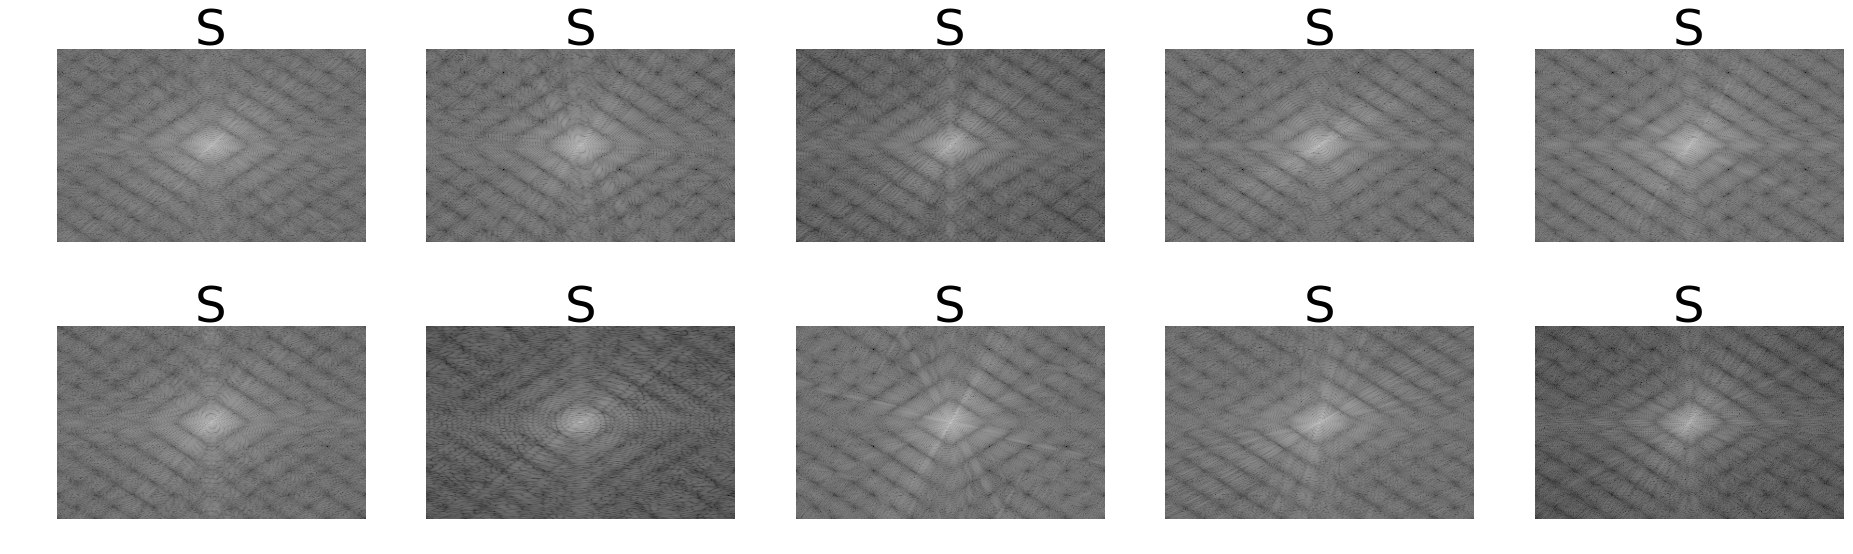

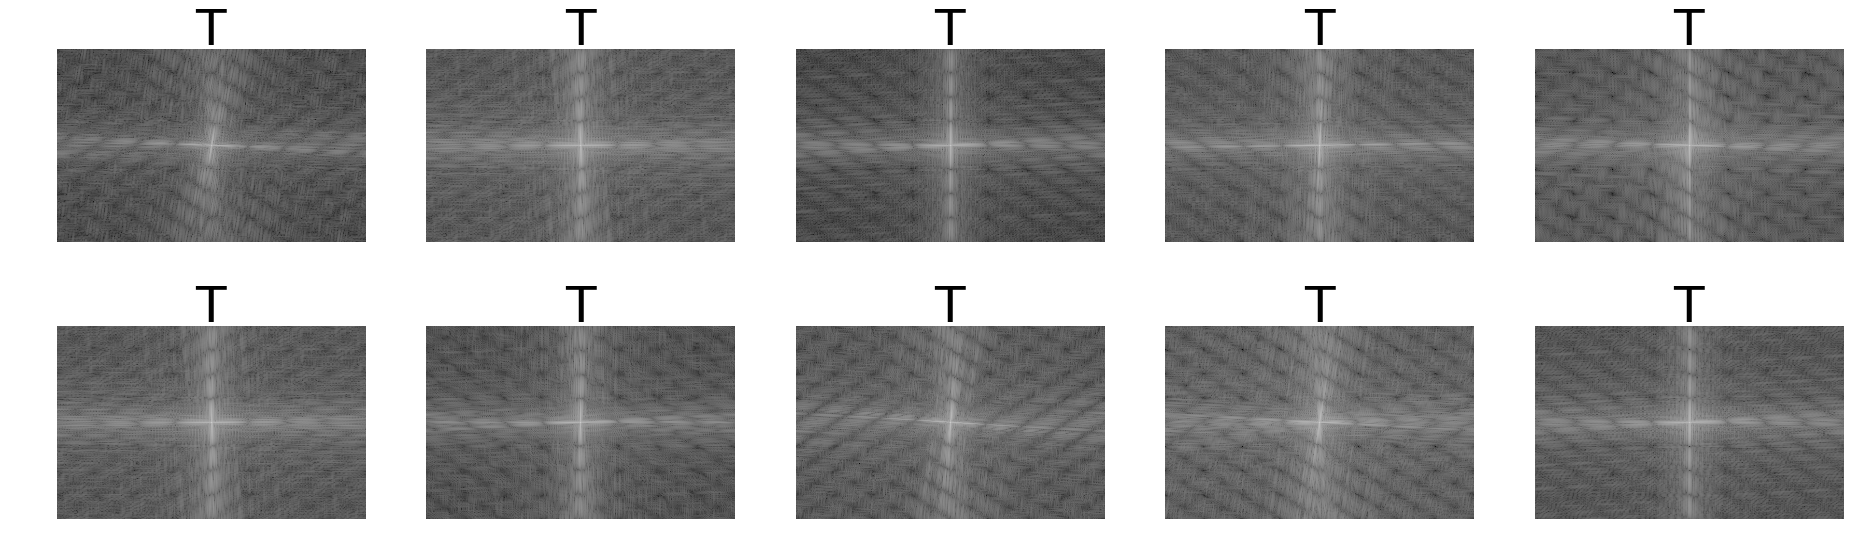

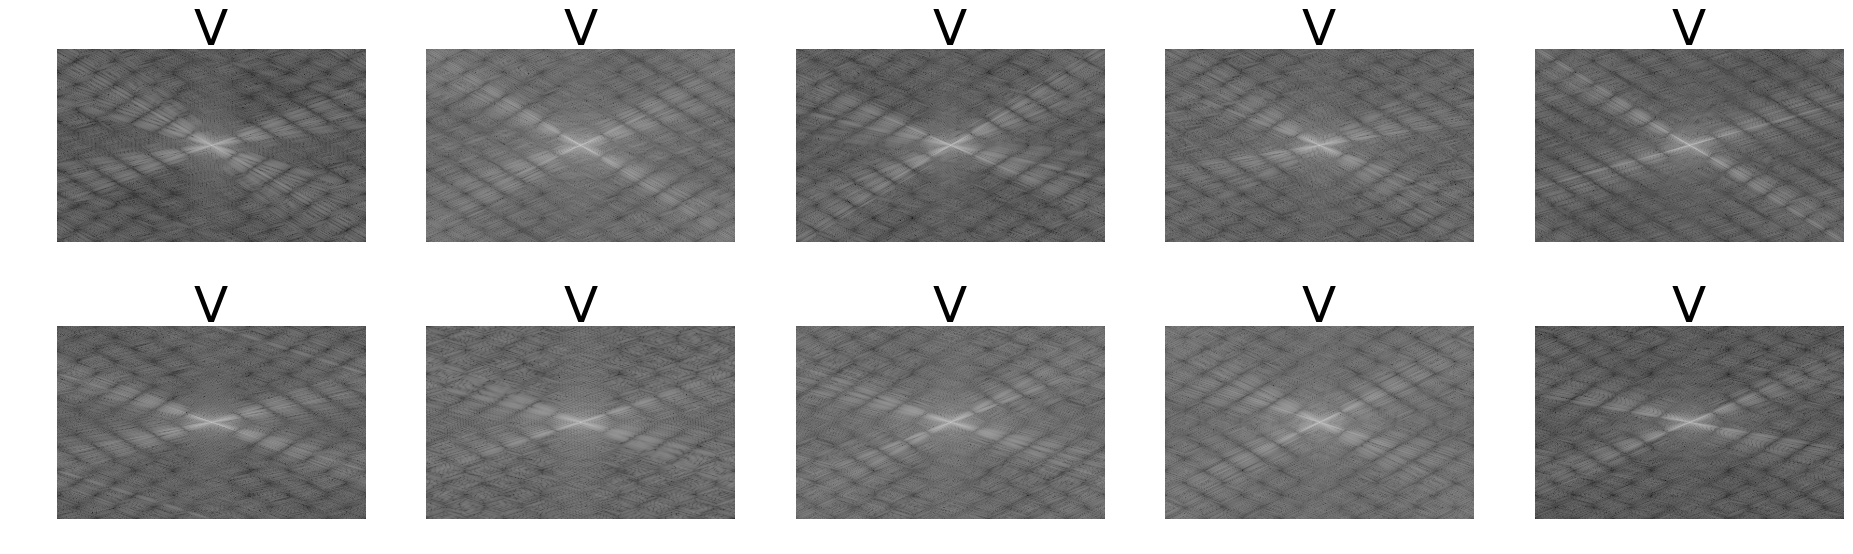

In [3]:
S = importLetter('S', 10, 'trainingSamples')
T = importLetter('T', 10, 'trainingSamples')
V = importLetter('V', 10, 'trainingSamples')

S_ft_all = fourierTransformAll(S)
T_ft_all = fourierTransformAll(T)
V_ft_all = fourierTransformAll(V)

plotFS('S', S_ft_all)
plotFS('T', T_ft_all)
plotFS('V', V_ft_all)

# S_i  = inverseFTAll(S)
# T_i  = inverseFTAll(T)
# V_i  = inverseFTAll(V)

In [4]:
def avgFS (fs):
    n, h, w   = fs.shape
    avgFS  = np.zeros((h, w), dtype=float)
    
    for i in range(10):
        avgFS = avgFS + np.absolute(fs[i])
    
    avgFS = avgFS / n
            
    return avgFS
                
def plotAvgFS (fs, n):
    fig = plt.figure()
    plotID = 1
#     letters = ['A', 'B']
    letters = ['S', 'T', 'V']
    for x in range(n):
        ax = fig.add_subplot(1, 3, plotID)
        ax.axis('off')
        ax.set_title(letters[plotID-1], {'fontsize': 50})
        ax.imshow(fs[x], cmap='gray')
        plotID += 1
    plt.show()

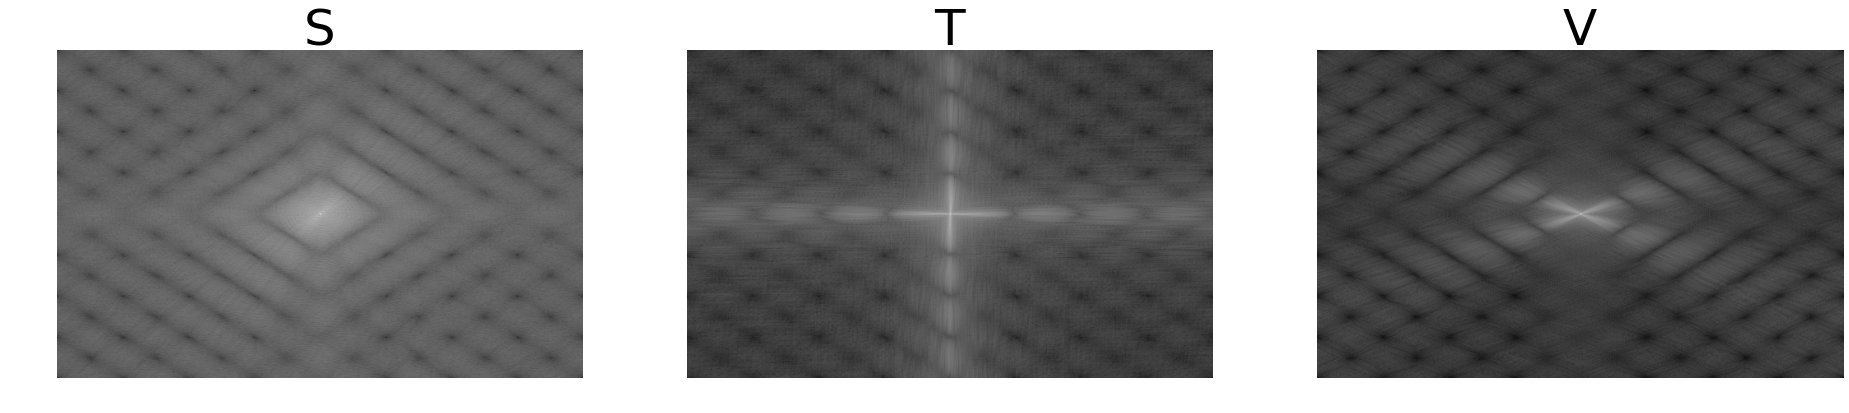

In [5]:
S_ft = avgFS(S_ft_all)
T_ft = avgFS(T_ft_all)
V_ft = avgFS(V_ft_all)

plotAvgFS([S_ft, T_ft, V_ft], 3)

In [6]:
def createMask1 (blankMask):
    h, w   = blankMask.shape
    xspan  = 20
    yspan  = 20
    square = 145

    for x in range(w):
        for y in range(h):
            if (((w/2) - xspan) < x < ((w/2) + xspan)):
                blankMask[y][x] = 1
            if (((h/2) - yspan) < y < ((h/2) + yspan)):
                blankMask[y][x] = 1
            if ((w/2 - square) < x < (w/2 + square) and (h/2 - square) < y < (h/2 + square)):
                blankMask[y][x] = 0
                
    return blankMask

def createMask2 (blankMask):
    h, w = blankMask.shape
    
    r   = 150
    xc1 = 270
    yc1 = 250
    xc2 = 370
    yc2 = 150
    
    for x in range(w):
        for y in range(h):
            if ((np.sqrt((xc1 - x) ** 2 + (yc1 - y) ** 2)) < r and
               (((-0.8)*np.pi) < (np.arctan2(yc1 - y,x - xc1)) < ((-0.5)*np.pi))):
                blankMask[y][x] = 1 # Bottom left
            if ((np.sqrt((xc1 - x) ** 2 + (yc2 - y) ** 2)) < r and
               (((0.5)*np.pi) < (np.arctan2(yc2 - y,x - xc1)) < ((0.8)*np.pi))):
                blankMask[y][x] = 1 # Top left
            if ((np.sqrt((xc2 - x) ** 2 + (yc1 - y) ** 2)) < r and
               (((-0.5)*np.pi) < (np.arctan2(yc1 - y,x - xc2)) < ((-0.2)*np.pi))):
                blankMask[y][x] = 1 # Bottom right
            if ((np.sqrt((xc2 - x) ** 2 + (yc2 - y) ** 2)) < r and
               (((0.2)*np.pi) < (np.arctan2(yc2 - y,x - xc2)) < ((0.5)*np.pi))):
                blankMask[y][x] = 1 # Top right
                
    return blankMask

def plotMasks (mask1, mask2):
    fig = plt.figure()
    
    ax = fig.add_subplot(1, 2, 1)
    ax.axis('off')
    ax.set_title('Mask 1', {'fontsize': 50})
    ax.imshow(mask1, cmap='gray')
    
    plt.show()
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(1, 2, 2)
    ax1.axis('off')
    ax1.set_title('Mask 2', {'fontsize': 50})
    ax1.imshow(mask2, cmap='gray')
    
    plt.show()

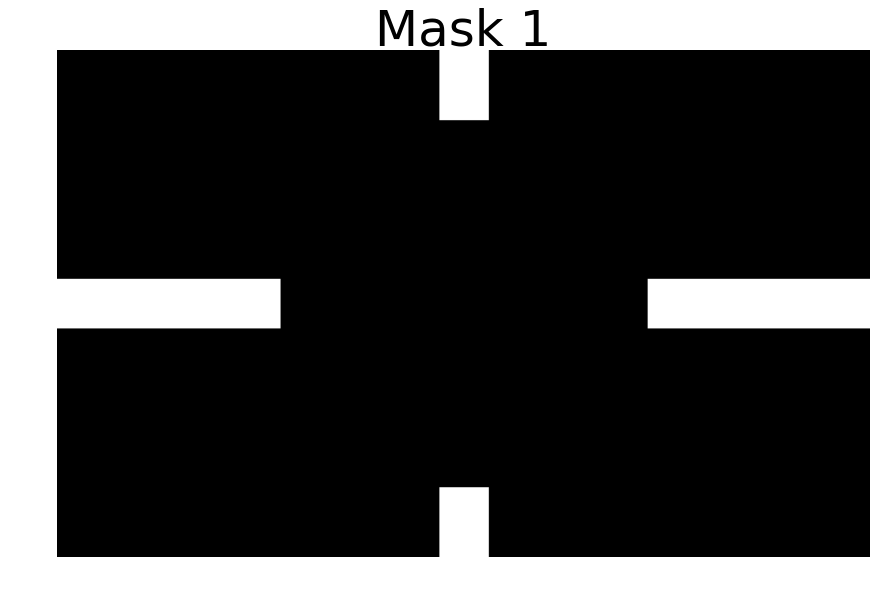

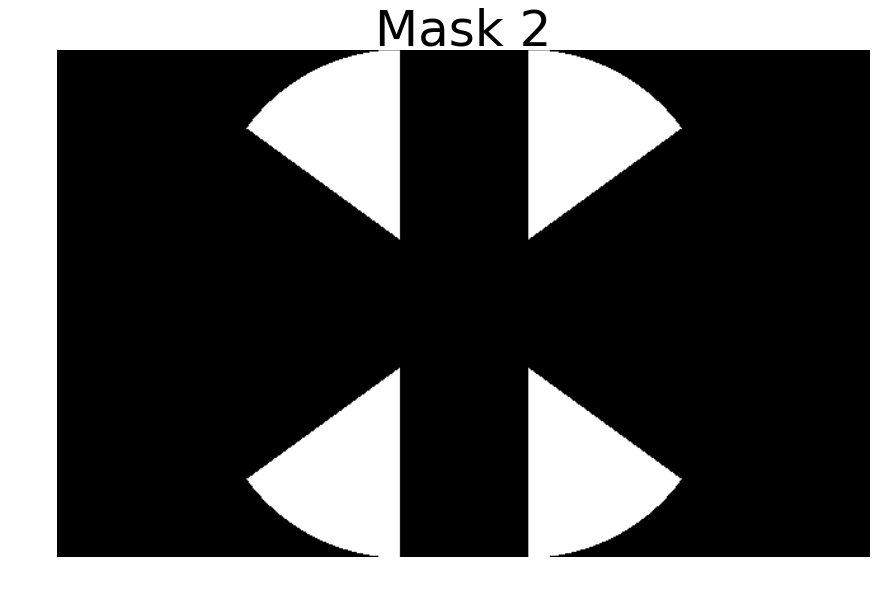

In [7]:
mask1 = createMask1(np.zeros((400, 640), dtype=float))
mask2 = createMask2(np.zeros((400, 640), dtype=float))

plotMasks(mask1, mask2)

In [8]:
def applyThreshold (image, threshold):
    h, w = image.shape
    
    for height in range(h):
        for width in range(w):
            if (image[height][width] < threshold):
                image[height][width] = 0
    
    return image

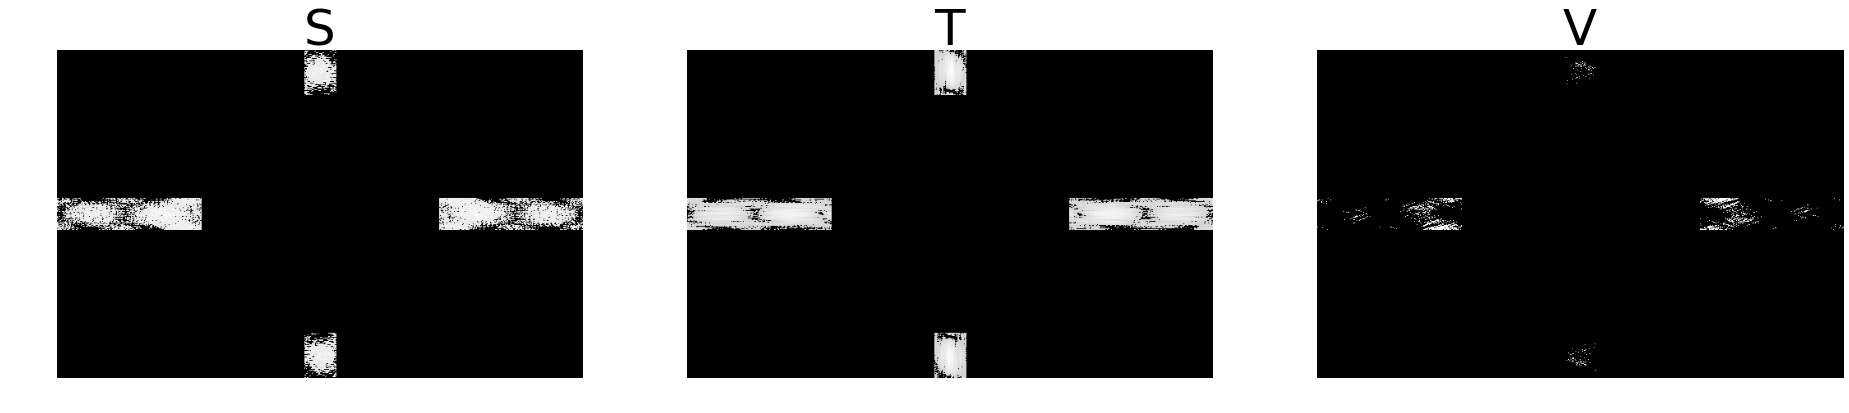

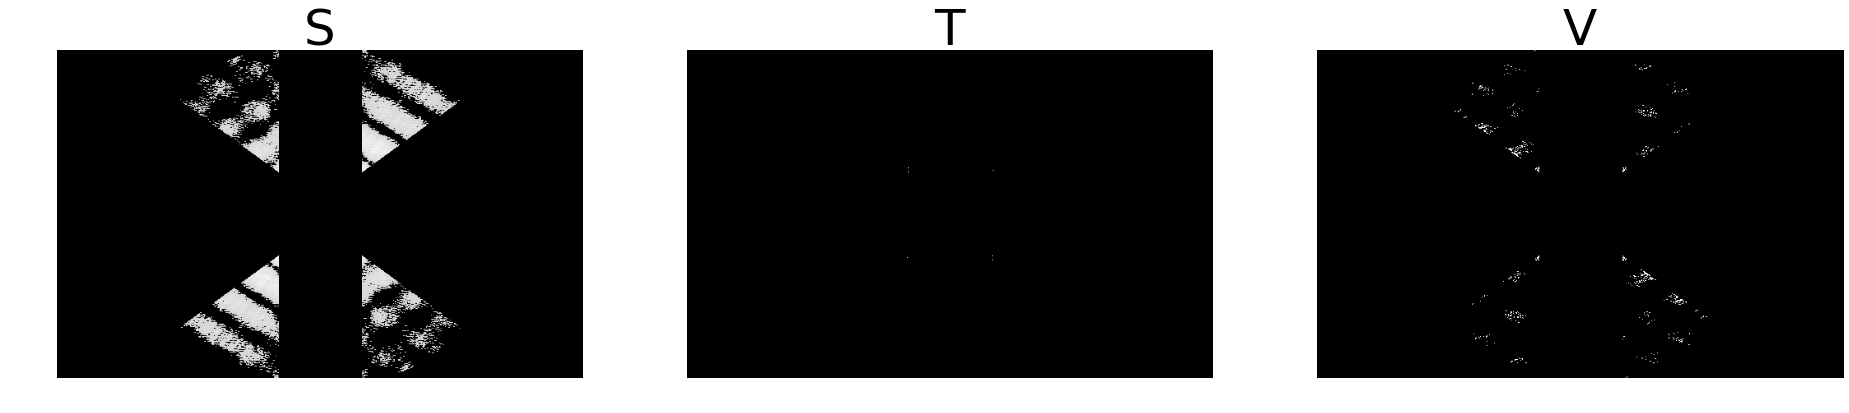

In [9]:
threshold = np.average([S_ft_all])

S_mask1 = applyThreshold(S_ft * mask1, threshold)
T_mask1 = applyThreshold(T_ft * mask1, threshold)
V_mask1 = applyThreshold(V_ft * mask1, threshold)

S_mask2 = applyThreshold(S_ft * mask2, threshold)
T_mask2 = applyThreshold(T_ft * mask2, threshold)
V_mask2 = applyThreshold(V_ft * mask2, threshold)

plotAvgFS([S_mask1, T_mask1, V_mask1], 3)
plotAvgFS([S_mask2, T_mask2, V_mask2], 3)

In [10]:
def extractFeatures (magSpecs, mask1, mask2):
    xs = [np.sum(m * mask1) for m in magSpecs]
    ys = [np.sum(m * mask2) for m in magSpecs]
    return xs, ys

In [11]:
S_ft_all = [applyThreshold(S, threshold) for S in S_ft_all]
T_ft_all = [applyThreshold(T, threshold) for T in T_ft_all]
V_ft_all = [applyThreshold(V, threshold) for V in V_ft_all]

S_xs, S_ys = extractFeatures(S_ft_all, mask1, mask2)
T_xs, T_ys = extractFeatures(T_ft_all, mask1, mask2)
V_xs, V_ys = extractFeatures(V_ft_all, mask1, mask2)

m = np.amax([S_xs, T_xs, V_xs, S_ys, T_ys, V_ys])

S_unit = [[S_xs[i], S_ys[i]] for i in range(10)] / m
T_unit = [[T_xs[i], T_ys[i]] for i in range(10)] / m
V_unit = [[V_xs[i], V_ys[i]] for i in range(10)] / m

training_unit = np.matrix(np.vstack((S_unit, T_unit, V_unit)))

In [12]:
def plotClassifier (training, S_test, T_test, V_test, A_test, B_test):
    n_neighbors = 1

    y = 10*[0] + 10*[1] + 10*[2]

    h = .001

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(training, y)

    x_min = 0.05
    x_max = 0.65
    y_min = 0
    y_max = 1.05

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    S_plot = plt.scatter(training[0:9,0], training[0:9,1], marker='o', color='red', s=700, label='S')
    T_plot = plt.scatter(training[10:20,0], training[10:20,1], marker='o', color='green', s=700, label='T')
    V_plot = plt.scatter(training[21:30,0], training[21:30,1], marker='o', color='blue', s=700, label='V')
    
    if S_test != None:
        S_test_plot = plt.scatter(S_test[:,0], S_test[:,1], marker='x', color='red', s=1300, label='S Test')
        T_test_plot = plt.scatter(T_test[:,0], T_test[:,1], marker='x', color='green', s=1300, label='T Test')
        V_test_plot = plt.scatter(V_test[:,0], V_test[:,1], marker='x', color='blue', s=1300, label='V Test')
            
    if A_test != None:
        A_test_plot = plt.scatter(A_test[:,0], A_test[:,1], marker='^', color='black', s=600, label='A Test')
        B_test_plot = plt.scatter(B_test[:,0], B_test[:,1], marker='s', color='black', s=600, label='B Test')

    plt.legend(loc='upper left', markerscale=0.5)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.show()

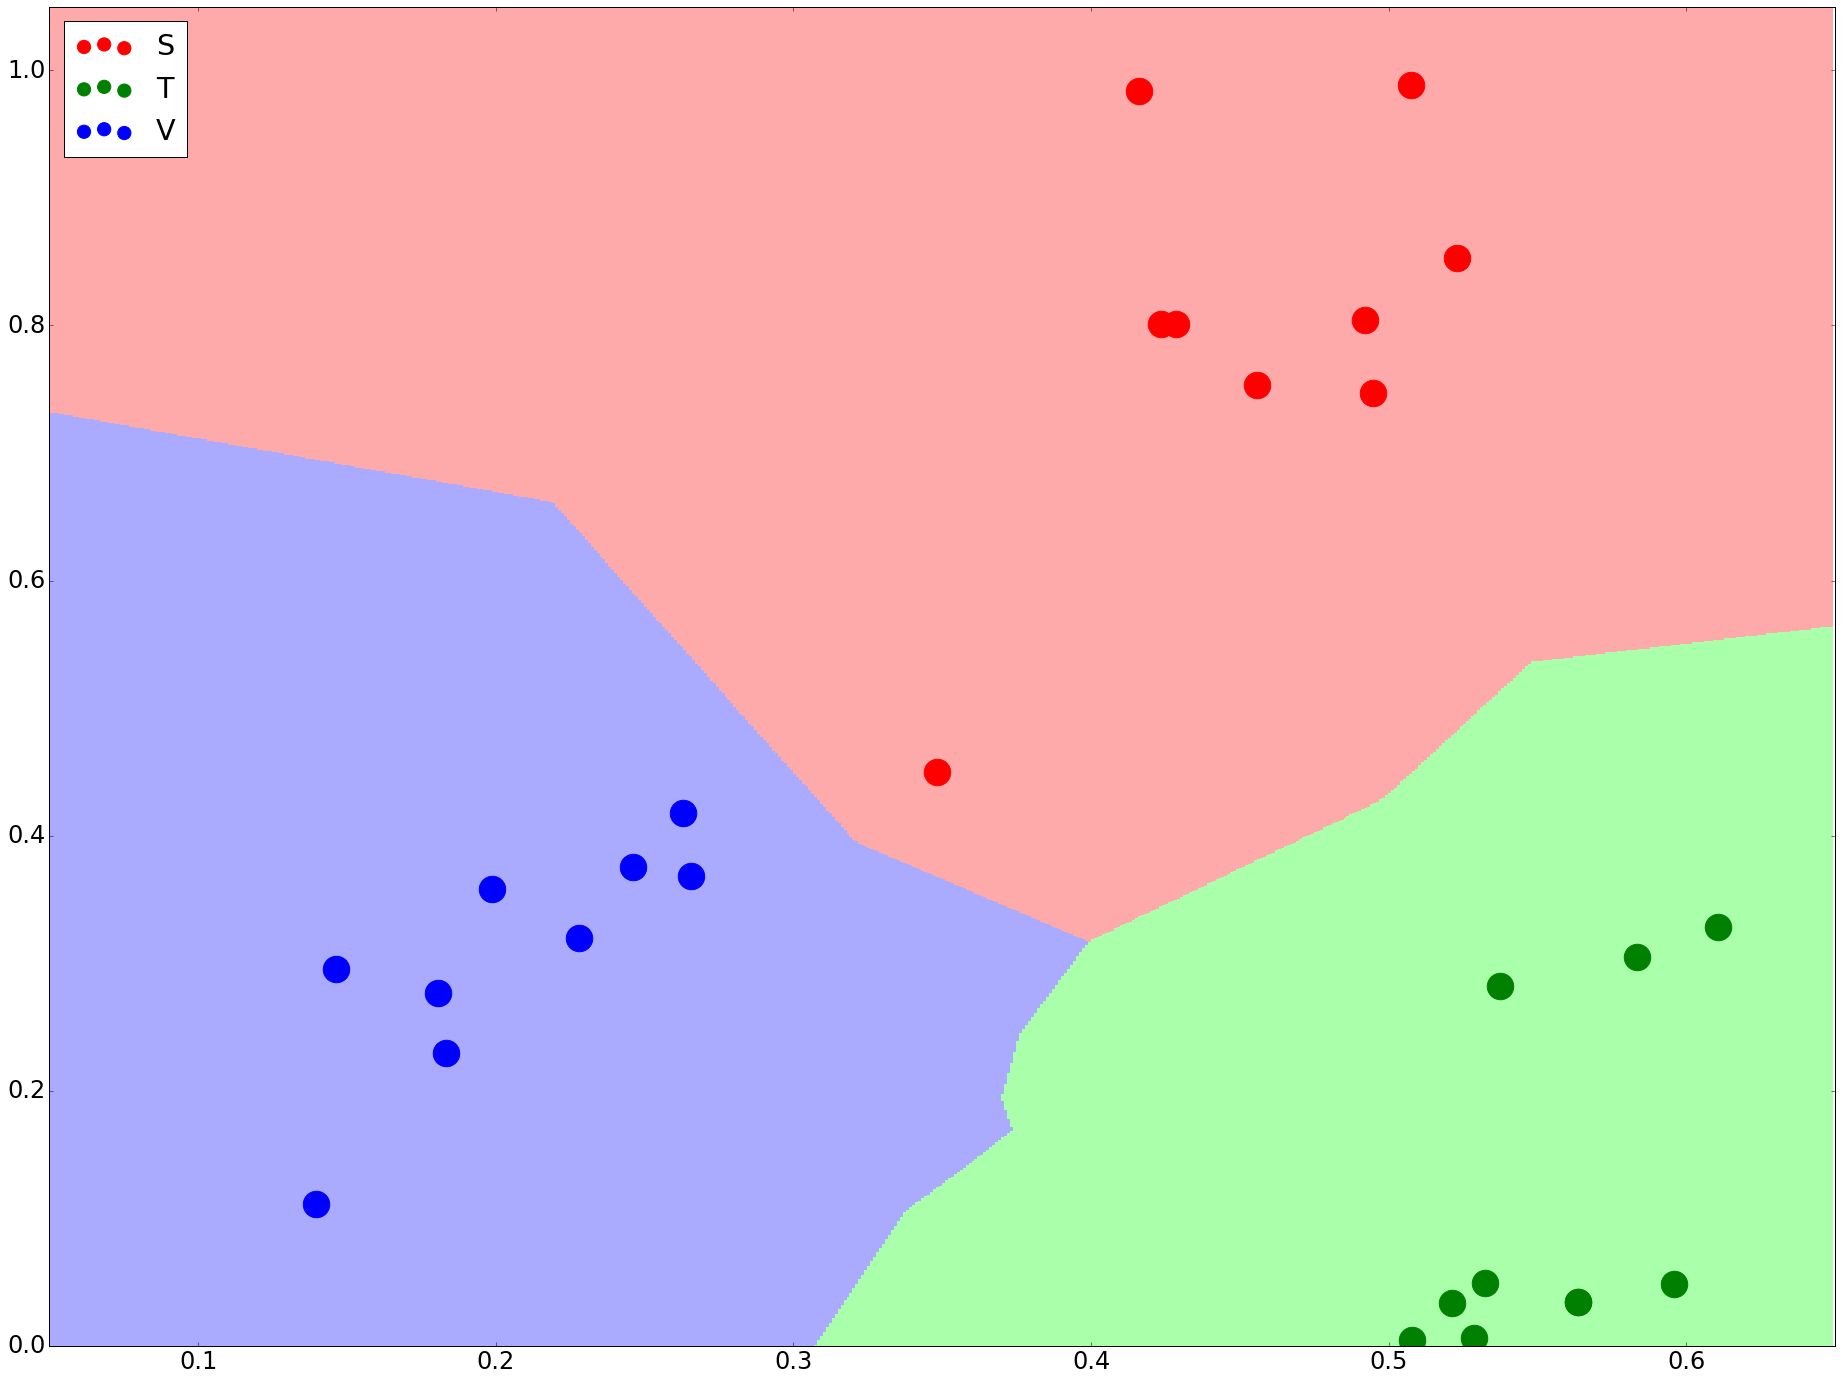

In [13]:
plotClassifier(training_unit, None, None, None, None, None)

In [14]:
S_test = importLetter('S', 6, 'testSamples')
T_test = importLetter('T', 6, 'testSamples')
V_test = importLetter('V', 6, 'testSamples')

S_ft_test = fourierTransformAll(S_test)
T_ft_test = fourierTransformAll(T_test)
V_ft_test = fourierTransformAll(V_test)

# plotFS('S Test', S_ft_test)
# plotFS('T Test', T_ft_test)
# plotFS('V Test', V_ft_test)

/Users/Oliver/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


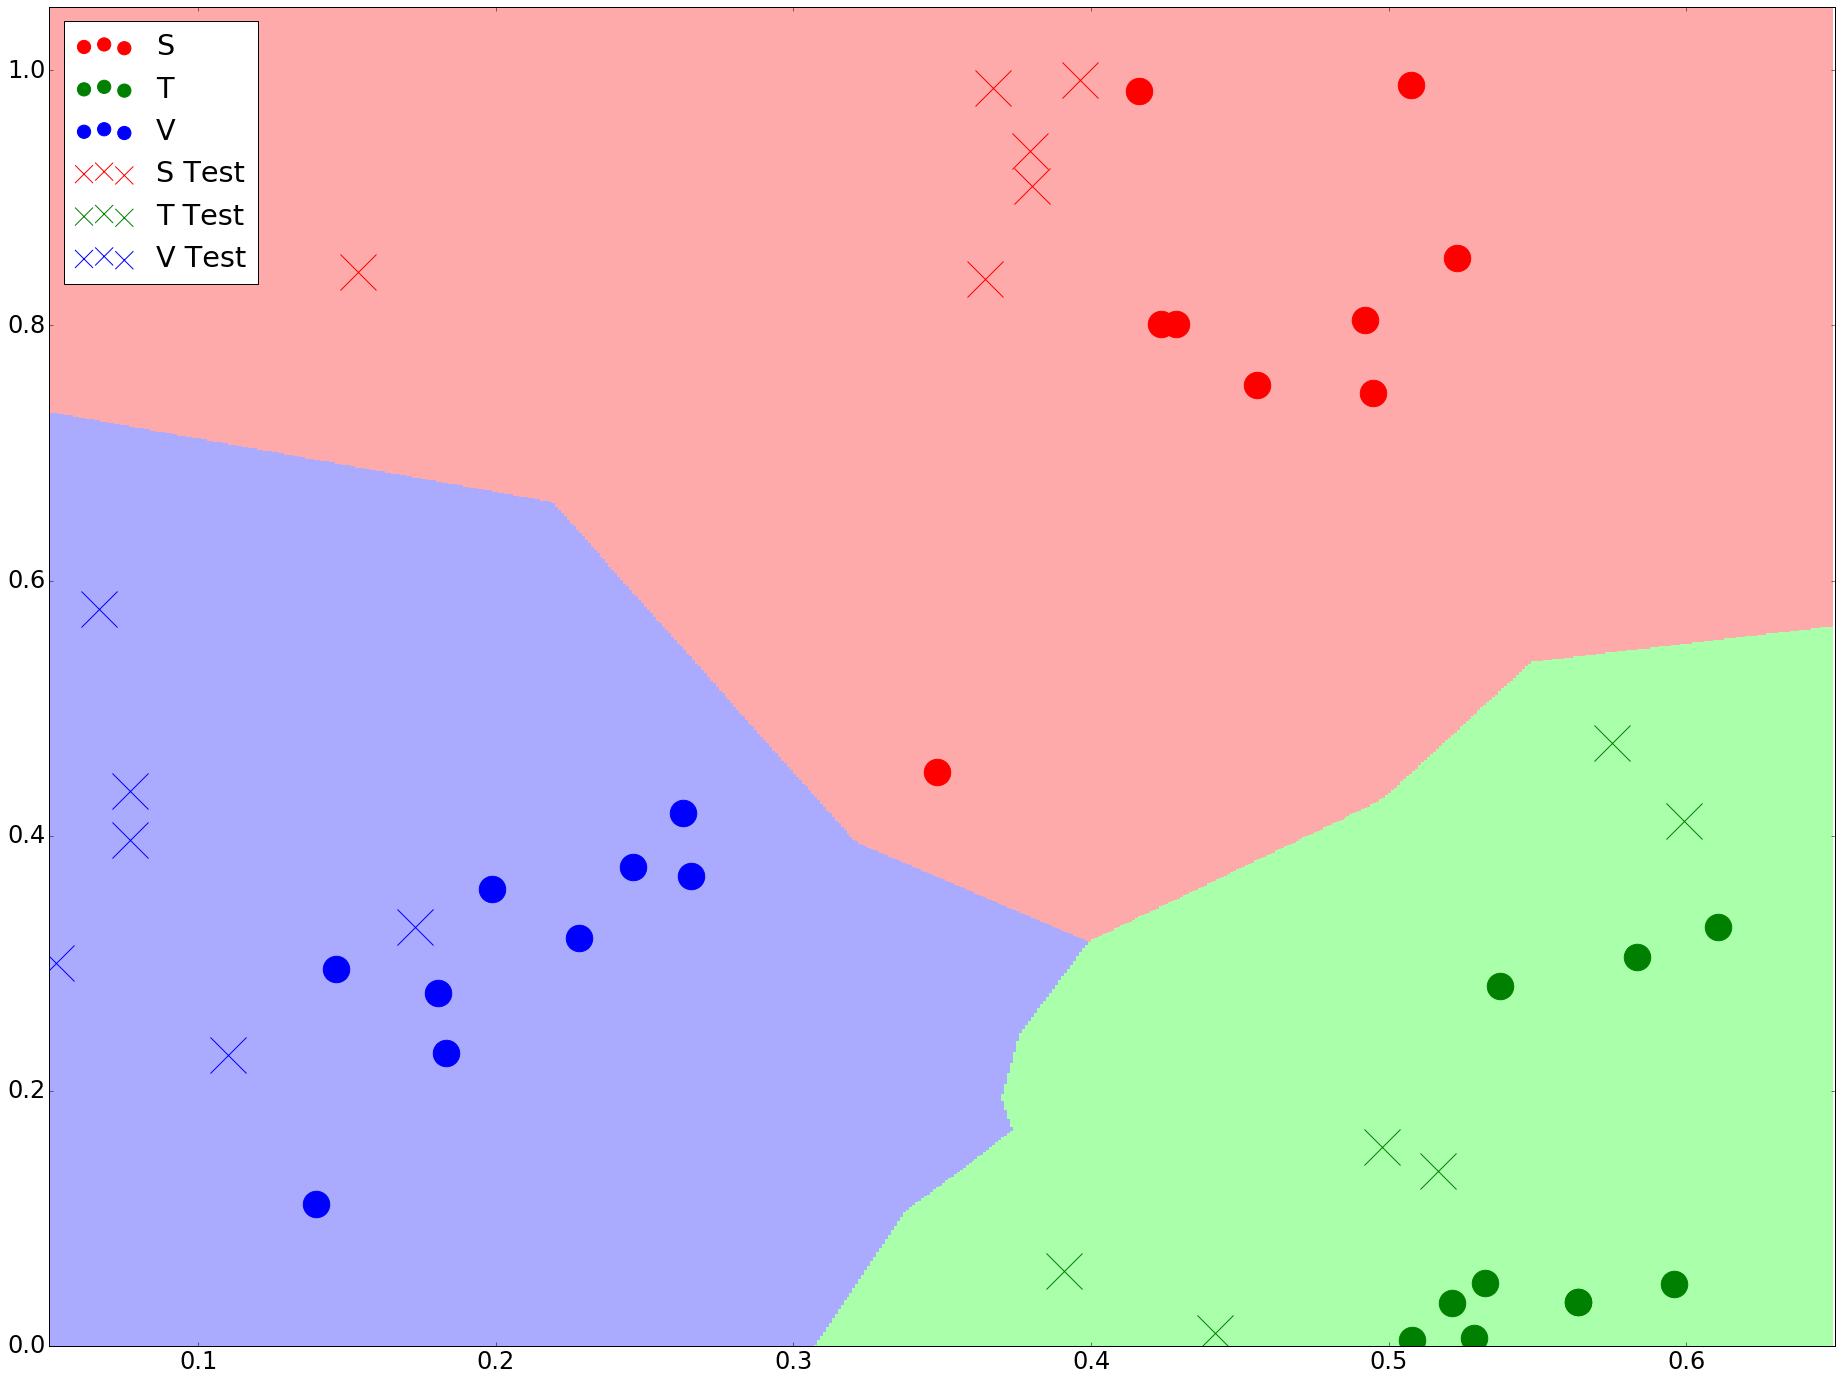

In [15]:
S_ft_test = [applyThreshold(S, threshold) for S in S_ft_test] 
T_ft_test = [applyThreshold(T, threshold) for T in T_ft_test]
V_ft_test = [applyThreshold(V, threshold) for V in V_ft_test]

S_test_xs, S_test_ys = extractFeatures(S_ft_test, mask1, mask2)
T_test_xs, T_test_ys = extractFeatures(T_ft_test, mask1, mask2)
V_test_xs, V_test_ys = extractFeatures(V_ft_test, mask1, mask2)

S_test_unit = [[S_test_xs[i], S_test_ys[i]] for i in range(6)] / m
T_test_unit = [[T_test_xs[i], T_test_ys[i]] for i in range(6)] / m
V_test_unit = [[V_test_xs[i], V_test_ys[i]] for i in range(6)] / m

plotClassifier(training_unit, S_test_unit, T_test_unit, V_test_unit, None, None)